# Experiment 3: Home Credit Default Risk

This notebook attempts to apply the lessons taught in Fast.ai Lesson 4 and 5 to another, similar dataset.

## Contents

1. Explore and visualise dataset.
2. Prepare dataset.
3. Build and train model.
4. Evaluation.
5. Ideas for improvements.

In [43]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

In [2]:
PATH = Path('./data/home-credit-default-risk')

In [4]:
PATH.mkdir(exist_ok=True)

## 1. Explore and visualise dataset

### Download and extract dataset

In [6]:
# Get dataset
!kaggle competitions download -c home-credit-default-risk --path={PATH}

sample_submission.csv.zip: Downloaded 117KB of 117KB
application_test.csv.zip: Downloaded 6MB of 6MB
application_train.csv.zip: Downloaded 34MB of 34MB
bureau.csv.zip: Downloaded 36MB of 36MB
bureau_balance.csv.zip: Downloaded 61MB of 61MB
previous_application.csv.zip: Downloaded 74MB of 74MB
credit_card_balance.csv.zip: Downloaded 94MB of 94MB
POS_CASH_balance.csv.zip: Downloaded 106MB of 106MB
installments_payments.csv.zip: Downloaded 267MB of 267MB
HomeCredit_columns_description.csv: Downloaded 37KB of 37KB


In [12]:
for file in os.listdir(PATH):
    if not file.endswith('zip'):
        continue
    
    file_path = PATH / file

    !unzip -q -d {PATH} {file_path}

In [13]:
!ls {PATH}

HomeCredit_columns_description.csv bureau_balance.csv.zip
POS_CASH_balance.csv               credit_card_balance.csv
POS_CASH_balance.csv.zip           credit_card_balance.csv.zip
application_test.csv               installments_payments.csv
application_test.csv.zip           installments_payments.csv.zip
application_train.csv              previous_application.csv
application_train.csv.zip          previous_application.csv.zip
bureau.csv                         sample_submission.csv
bureau.csv.zip                     sample_submission.csv.zip
bureau_balance.csv


### application_train

From Kaggle data page:

*"This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. One row represents one loan in our data sample."*

In [15]:
train_df = pd.read_csv(PATH / 'application_train.csv')

In [16]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
len(train_df)

307511

Number of rows where `TARGET = 1`:

In [20]:
print("Num target = 1: ", len(train_df[train_df['TARGET'] == 1]))
print("Num target = 0: ", len(train_df[train_df['TARGET'] == 0]))

Num target = 1:  24825
Num target = 0:  282686


In [21]:
test_df = pd.read_csv(PATH / 'application_test.csv')

In [22]:
test_df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


There's a file called `HomeCredit_columns_description.csv` that has a description of each column. Let's take a look at that.

In [29]:
column_desc = pd.read_csv(PATH / 'HomeCredit_columns_description.csv', encoding='latin_1')

In [30]:
column_desc.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [34]:
column_desc[column_desc['Table'] == 'application_{train|test}.csv']

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [37]:
column_desc[column_desc['Table'] == 'application_{train|test}.csv'].iloc[1]['Description']

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

#### Distribution of income

I'm removing outliers, since the large values can drown out the histogram.

In [71]:
income_series = train_df['AMT_INCOME_TOTAL']

In [74]:
print(f'Largest income: {max(income_series)}')
print(f'Smallest income: {min(income_series)}')
print(f'Mean income: {income_series.mean()}')
print(f'Std income: {income_series.std()}')

Largest income: 117000000.0
Smallest income: 25650.0
Mean income: 168797.9192969845
Std income: 237123.14627885626


In [76]:
income_mean = income_series.mean()
income_series_cleaned = income_series[(income_series - income_mean).abs() <= 3 * income_series.std()]

//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


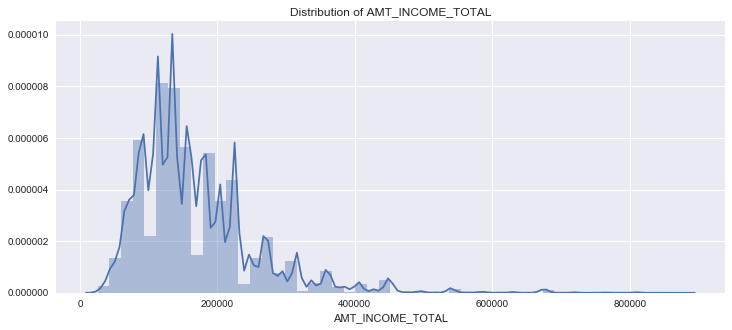

In [77]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_INCOME_TOTAL")
ax = sns.distplot(income_series_cleaned)

#### Distribution of credit amount of loans

//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


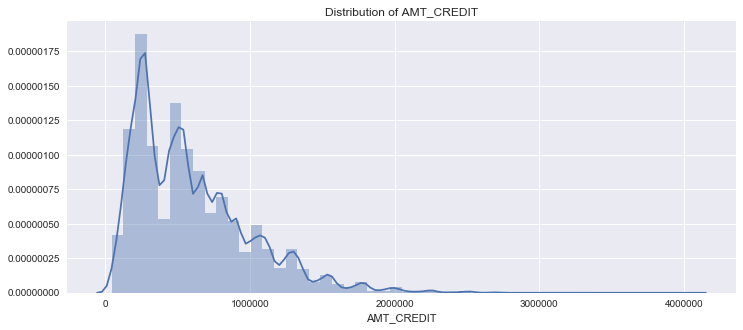

In [78]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(train_df['AMT_CREDIT'])

#### Distribution of annuity

//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


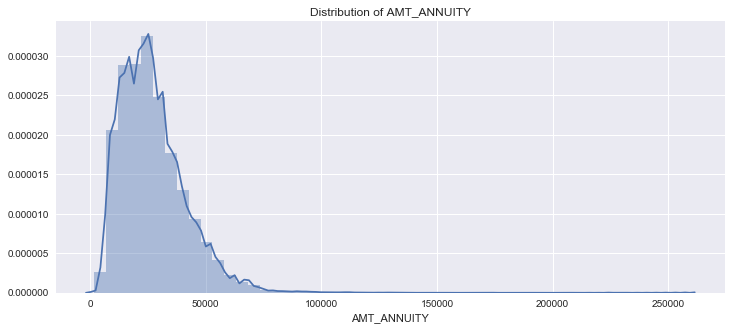

In [81]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_ANNUITY")
ax = sns.distplot(train_df['AMT_ANNUITY'].dropna())

#### Balance of dataset

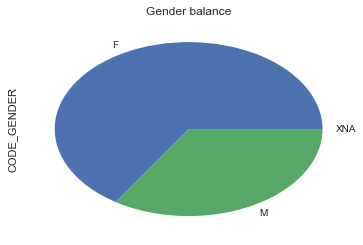

In [93]:
train_df['CODE_GENDER'].value_counts().plot(kind='pie', title='Gender balance')

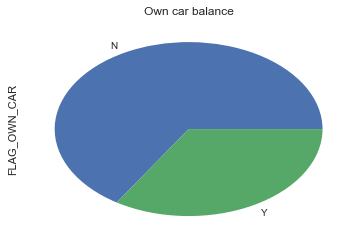

In [94]:
train_df['FLAG_OWN_CAR'].value_counts().plot(kind='pie', title='Own car balance')

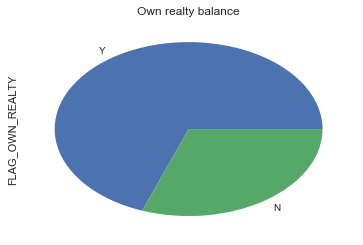

In [99]:
train_df['FLAG_OWN_REALTY'].value_counts().plot(kind='pie', title='Own realty balance')

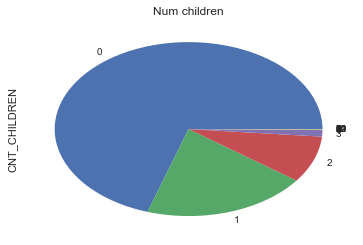

In [104]:
train_df['CNT_CHILDREN'].value_counts().plot(kind='pie', title='Num children')

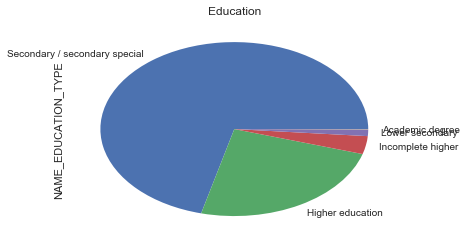

In [106]:
train_df['NAME_EDUCATION_TYPE'].value_counts().plot(kind='pie', title='Education')

Now let's check out the other DFs.

In [109]:
dfs = []

for file in [
    'POS_CASH_balance.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv',
    'installments_payments.csv', 'previous_application.csv'
]:
    dfs.append(pd.read_csv(PATH / file))

In [168]:
pos, bureau, bureau_balance, credit_card_balance, installments_payments, previous_application = dfs

### POS

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [111]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [216]:
pos_col_desc = column_desc[column_desc['Table'] == 'POS_CASH_balance.csv']

In [217]:
for idx, row in pos_col_desc.iterrows():
    print(f"* {row['Row'].strip()}: {row['Description']}")

* SK_ID_PREV: ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
* SK_ID_CURR: ID of loan in our sample
* MONTHS_BALANCE: Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )
* CNT_INSTALMENT: Term of previous credit (can change over time)
* CNT_INSTALMENT_FUTURE: Installments left to pay on the previous credit
* NAME_CONTRACT_STATUS: Contract status during the month
* SK_DPD: DPD (days past due) during the month of previous credit
* SK_DPD_DEF: DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit


In [183]:
pos[pos['SK_ID_CURR'] == 100001].sort_values(by='MONTHS_BALANCE', ascending=False)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2197888,1369693,100001,-53,4.0,0.0,Completed,0,0
4704415,1369693,100001,-54,4.0,1.0,Active,0,0
7823681,1369693,100001,-55,4.0,2.0,Active,0,0
8789081,1369693,100001,-56,4.0,3.0,Active,0,0
7167007,1369693,100001,-57,4.0,4.0,Active,0,0
4928574,1851984,100001,-93,4.0,0.0,Completed,0,0
8531326,1851984,100001,-94,4.0,0.0,Active,0,0
1891462,1851984,100001,-95,4.0,1.0,Active,7,7
1261679,1851984,100001,-96,4.0,2.0,Active,0,0


* I could take an approach of including each months balance values as a column:
  
  ``MONTHS_BALANCER_-96_SK_DPD``
  
  Going to create a lot of columns though.
  
* Another alternative would be to sum the ``SK_DPD`` and ``SK_DPD_DEF`` values, but that doesn't capture the other information that could be useful.

* I could also create previous loan columns:
  loan_1_installment: 4
  loan_1_days_past_due: 7
  
* Could consider average DPD per loan.

### Bureau

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [186]:
pos_col_desc = column_desc[column_desc['Table'] == 'bureau.csv']

In [187]:
for idx, row in pos_col_desc.iterrows():
    print(f"* {row['Row'].strip()}: {row['Description']}")

* SK_ID_CURR: ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau 
* SK_BUREAU_ID: Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
* CREDIT_ACTIVE: Status of the Credit Bureau (CB) reported credits
* CREDIT_CURRENCY: Recoded currency of the Credit Bureau credit
* DAYS_CREDIT: How many days before current application did client apply for Credit Bureau credit
* CREDIT_DAY_OVERDUE: Number of days past due on CB credit at the time of application for related loan in our sample
* DAYS_CREDIT_ENDDATE: Remaining duration of CB credit (in days) at the time of application in Home Credit
* DAYS_ENDDATE_FACT: Days since CB credit ended at the time of application in Home Credit (only for closed credit)
* AMT_CREDIT_MAX_OVERDUE: Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
* CNT_CREDIT_PROLONG: How many times was the Credit 

In [185]:
bureau[bureau['SK_ID_CURR'] == 100001]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
248484,100001,5896630,Closed,currency 1,-857,0,-492.0,-553.0,NaN,0,112500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
248485,100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,NaN,0,279720.0,0.0,0.0,0.0,Consumer credit,-155,0.0
248486,100001,5896632,Closed,currency 1,-879,0,-514.0,-544.0,NaN,0,91620.0,0.0,0.0,0.0,Consumer credit,-155,0.0
248487,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
248488,100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,337680.0,113166.0,0.0,0.0,Consumer credit,-6,4630.5
248489,100001,5896635,Active,currency 1,-49,0,1778.0,NaN,NaN,0,378000.0,373239.0,0.0,0.0,Consumer credit,-16,10822.5
248490,100001,5896636,Active,currency 1,-320,0,411.0,NaN,NaN,0,168345.0,110281.5,NaN,0.0,Consumer credit,-10,9364.5


All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

### Bureau Balance

Monthly balances of previous credits in Credit Bureau.

This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [190]:
bureau_balance_col_desc = column_desc[column_desc['Table'] == 'bureau_balance.csv']

In [191]:
for idx, row in bureau_balance_col_desc.iterrows():
    print(f"* {row['Row'].strip()}: {row['Description']}")

* SK_BUREAU_ID: Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table 
* MONTHS_BALANCE: Month of balance relative to application date (-1 means the freshest balance date)
* STATUS: Status of Credit Bureau loan during the month (active, closed, DPD0-30, [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60, 5 means DPD 120+ or sold or written off ] )


In [193]:
bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5896630].head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
4040588,5896630,0,C
4040589,5896630,-1,C
4040590,5896630,-2,C
4040591,5896630,-3,C
4040592,5896630,-4,C


### Credit card balance

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [194]:
credit_card_balance_col_desc = column_desc[column_desc['Table'] == 'credit_card_balance.csv']

In [195]:
for idx, row in credit_card_balance_col_desc.iterrows():
    print(f"* {row['Row'].strip()}: {row['Description']}")

* SK_ID_PREV: ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
* SK_ID_CURR: ID of loan in our sample
* MONTHS_BALANCE: Month of balance relative to application date (-1 means the freshest balance date)
* AMT_BALANCE: Balance during the month of previous credit
* AMT_CREDIT_LIMIT_ACTUAL: Credit card limit during the month of the previous credit
* AMT_DRAWINGS_ATM_CURRENT: Amount drawing at ATM during the month of the previous credit
* AMT_DRAWINGS_CURRENT: Amount drawing during the month of the previous credit
* AMT_DRAWINGS_OTHER_CURRENT: Amount of other drawings during the month of the previous credit
* AMT_DRAWINGS_POS_CURRENT: Amount drawing or buying goods during the month of the previous credit
* AMT_INST_MIN_REGULARITY: Minimal installment for this month of the previous credit
* AMT_PAYMENT_CURRENT: How much did the client pay during the month on the previous credit
* AMT_PAYMENT_TOT

In [199]:
credit_card_balance[credit_card_balance['SK_ID_CURR'] == 378907]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.500,0.0,877.500,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
122799,2562384,378907,-30,45328.320,270000,0.0,0.000,0.0,0.000,2332.035,...,45670.275,45670.275,0.0,0,0.0,0.0,18.0,Active,0,0
153474,2562384,378907,-8,129.240,135000,0.0,22005.000,0.0,22005.000,2250.000,...,0.000,0.000,0.0,1,0.0,1.0,33.0,Active,0,0
330701,2562384,378907,-2,28.575,9000,0.0,0.000,0.0,0.000,1916.910,...,28.575,28.575,0.0,0,0.0,0.0,39.0,Active,0,0
419198,2562384,378907,-12,0.000,45000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,29.0,Active,0,0
561468,2562384,378907,-39,56570.940,270000,0.0,0.000,0.0,0.000,2761.740,...,56570.940,56570.940,0.0,0,0.0,0.0,9.0,Active,6,6
577279,2562384,378907,-27,43030.845,270000,0.0,0.000,0.0,0.000,2250.000,...,43360.290,43360.290,0.0,0,0.0,0.0,21.0,Active,0,0
596084,2562384,378907,-19,0.000,45000,0.0,0.000,0.0,0.000,281.475,...,0.000,0.000,0.0,0,0.0,0.0,29.0,Active,0,0
722949,2562384,378907,-13,0.000,45000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,29.0,Active,0,0
889286,2562384,378907,-17,0.000,45000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,29.0,Active,0,0


### Installments Payments

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.

There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [200]:
installments_payments_col_desc = column_desc[column_desc['Table'] == 'installments_payments.csv']

In [201]:
for idx, row in installments_payments_col_desc.iterrows():
    print(f"* {row['Row'].strip()}: {row['Description']}")

* SK_ID_PREV: ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
* SK_ID_CURR: ID of loan in our sample
* NUM_INSTALMENT_VERSION: Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
* NUM_INSTALMENT_NUMBER: On which installment we observe payment
* DAYS_INSTALMENT: When the installment of previous credit was supposed to be paid (relative to application date of current loan)
* DAYS_ENTRY_PAYMENT: When was the installments of previous credit paid actually (relative to application date of current loan)
* AMT_INSTALMENT: What was the prescribed installment amount of previous credit on this installment
* AMT_PAYMENT: What the client actually paid on previous credit on this installment


In [207]:
installments_payments[installments_payments['SK_ID_CURR'] == 161674].sort_values(by=['SK_ID_PREV', 'DAYS_INSTALMENT'], ascending=False)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1006147,2841573,161674,1.0,10,-1854.0,-1860.0,3647.700,3647.700
2407765,2841573,161674,1.0,9,-1884.0,-1888.0,3703.275,3703.275
581223,2841573,161674,1.0,8,-1914.0,-1917.0,3703.275,3703.275
489749,2841573,161674,1.0,7,-1944.0,-1950.0,3703.275,3703.275
819151,2841573,161674,1.0,6,-1974.0,-1980.0,3703.275,3703.275
1745693,2841573,161674,1.0,5,-2004.0,-2007.0,3703.275,3703.275
3460941,2841573,161674,1.0,4,-2034.0,-2037.0,3703.275,3703.275
3704788,2841573,161674,1.0,3,-2064.0,-2070.0,3703.275,3703.275
2456163,2841573,161674,1.0,2,-2094.0,-2100.0,3703.275,3703.275
1347951,2841573,161674,1.0,1,-2124.0,-2129.0,3703.275,3703.275


### Previous Application

All previous applications for Home Credit loans of clients who have loans in our sample.

There is one row for each previous application related to loans in our data sample.

In [210]:
previous_application_col_desc = column_desc[column_desc['Table'] == 'previous_application.csv']

In [211]:
for idx, row in previous_application_col_desc.iterrows():
    print(f"* {row['Row'].strip()}: {row['Description']}")

* SK_ID_PREV: ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit) 
* SK_ID_CURR: ID of loan in our sample
* NAME_CONTRACT_TYPE: Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application
* AMT_ANNUITY: Annuity of previous application
* AMT_APPLICATION: For how much credit did client ask on the previous application
* AMT_CREDIT: Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT
* AMT_DOWN_PAYMENT: Down payment on the previous application
* AMT_GOODS_PRICE: Goods price of good that client asked for (if applicable) on the previous application
* WEEKDAY_APPR_PROCESS_START: On whic

In [215]:
previous_application[previous_application['SK_ID_CURR'] == 271877]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
735737,1696966,271877,Consumer loans,68258.655,1800000.0,1754721.0,180000.0,1800000.0,SATURDAY,18,...,Furniture,36.0,low_normal,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN
1567518,2154916,271877,Consumer loans,12417.390,108400.5,119848.5,0.0,108400.5,SUNDAY,14,...,Furniture,12.0,middle,POS industry with interest,365243.0,-512.0,-182.0,-392.0,-387.0,0.0


## 2. Prepare dataset